In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
# 데이터 로드
X = np.load('drive/MyDrive/Heart Disease/dataset/train/X_train_A4C.npy')
Y = np.load('drive/MyDrive/Heart Disease/dataset/train/Y_train_A4C.npy')
X_val = np.load('drive/MyDrive/Heart Disease/dataset/validation/X_val_A4C.npy')
Y_val = np.load('drive/MyDrive/Heart Disease/dataset/validation/Y_val_A4C.npy')

In [ ]:
num_train_examples = len(X)
num_test_examples = len(X_val)

## DataLoader

In [ ]:
!pip install tensorflow-addons

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import math

img_shape = (480, 640, 3)
    
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random.uniform([],  
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

def flip_img(horizontal_flip, vertically_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)), 
                                lambda: (tr_img, label_img))
    if vertically_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_up_down(tr_img), tf.image.flip_up_down(label_img)), 
                                lambda: (tr_img, label_img))
    return tr_img, label_img


def rotate_img(tr_img, label_img):
    rotate_prob = tf.random.uniform([], 0.0, 1.0)
    degrees = tf.random.uniform([], -45, 45)
    tr_img, label_img = tf.cond(tf.less(rotate_prob, 0.5),
                            lambda: (tfa.image.rotate(tr_img, degrees * math.pi / 180, interpolation = 'BILINEAR', fill_mode= 'reflect'), tfa.image.rotate(label_img, degrees * math.pi / 180, interpolation = 'BILINEAR' , fill_mode= 'reflect')), 
                            lambda: (tr_img, label_img))
    return tr_img, label_img

In [ ]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.01,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,    # Random left right flip,
             vertically_flip=True,    # Random up down flip,
             width_shift_range=.1,    # Randomly translate the image horizontally
             height_shift_range=.1):    # Randomly translate the image vertically
     
    if resize is not None:
        # Resize both images
        img = tf.expand_dims(tf.argmax(img,axis=-1),-1)
        label_img = tf.expand_dims(tf.argmax(label_img,axis=-1),-1)
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, vertically_flip, img, label_img)                               
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)                      
    img, label_img = rotate_img(img, label_img)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [ ]:
import tensorflow as tf

def _process_pathnames(X, Y):
    img = tf.convert_to_tensor(X)
    label = tf.convert_to_tensor(Y)
    return img, label

In [ ]:
batch_size = 16

import functools
import tensorflow as tf

def gen_train():
    for x, y in zip(X, Y):
        yield _process_pathnames(x, y)

def gen_test():
    for x, y in zip(X_val, Y_val):
        yield _process_pathnames(x, y)

def get_dataset(#X,Y, 
            preproc_fn = functools.partial(_augment),
            threads = 2,
            batch_size = batch_size,
            is_train = True):
  if is_train:
    dataset = tf.data.Dataset.from_generator(gen_train, (tf.float32, tf.float32), ((480, 640, 3), (480, 640, 1)))
  else:
    dataset = tf.data.Dataset.from_generator(gen_test, (tf.float32, tf.float32), ((480, 640, 3), (480, 640, 1)))
  dataset = dataset.batch(batch_size)
  print(dataset)
  return dataset

In [ ]:
train_dataset = get_dataset(is_train=True)
test_dataset = get_dataset(is_train=False)

In [ ]:
train_dataset.take(1)

<TakeDataset shapes: ((None, 480, 640, 3), (None, 480, 640, 1)), types: (tf.float32, tf.float32)>

## Model

In [ ]:
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from tensorflow.python.keras import losses

In [ ]:
class Conv(tf.keras.layers.Layer):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.2)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.dropout(x)
        x = layers.ReLU()(x)
        return x

In [ ]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs):
        conv_block = self.conv1(inputs)
        conv_block = self.conv2(conv_block)
        return conv_block

class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.Conv2D(num_filters, 3, padding='same', strides=2, activation='relu', kernel_initializer='he_normal')
        
    def call(self, inputs):
        encoder = self.conv_block(inputs)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder                                         


class DecoderBlock(tf.keras.layers.Layer):                                         
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', kernel_initializer='he_normal')
        self.bn = layers.BatchNormalization()
        self.conv_block = ConvBlock(num_filters)

    def call(self, input_tensor, concat_tensor):
        decoder = self.convT(input_tensor)
        decoder = self.bn(decoder)
        decoder = layers.ReLU()(decoder)
        decoder = layers.concatenate([decoder,concat_tensor])
        decoder = self.conv_block(decoder)

        return decoder

In [ ]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(16)
        self.encoder_block2 = EncoderBlock(32)
        self.encoder_block3 = EncoderBlock(64)
        self.encoder_block4 = EncoderBlock(128)
        self.encoder_block5 = EncoderBlock(256)
        
        self.center = ConvBlock(512)
        
        self.flatten = tf.keras.layers.Flatten()
        self.output_linear = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
        
        self.decoder_block5 = DecoderBlock(256)
        self.decoder_block4 = DecoderBlock(128)
        self.decoder_block3 = DecoderBlock(64)
        self.decoder_block2 = DecoderBlock(32) 
        self.decoder_block1 = DecoderBlock(16) 

        self.output_conv = layers.Conv2D(1, 1, padding='same', activation='sigmoid', kernel_initializer='glorot_uniform' )

    def call(self, inputs):
        encoder1_pool, encoder1_skip = self.encoder_block1(inputs)
        encoder2_pool, encoder2_skip = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3_skip = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4_skip = self.encoder_block4(encoder3_pool)
        encoder5_pool, encoder5_skip = self.encoder_block5(encoder4_pool)
        
        center = self.center(encoder5_pool)
        
        decoder5 = self.decoder_block5(center, encoder5_skip)
        decoder4 = self.decoder_block4(decoder5,encoder4_skip)
        decoder3 = self.decoder_block3(decoder4,encoder3_skip)
        decoder2 = self.decoder_block2(decoder3,encoder2_skip)
        decoder1 = self.decoder_block1(decoder2,encoder1_skip)

        outputs = self.output_conv(decoder1)
        return outputs

In [ ]:
model = UNet()
outputs = model(tf.random.normal([batch_size, 480, 640, 3]))
print(outputs.shape)

(16, 480, 640, 1)


In [ ]:
model.summary()

Model: "u_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_block (EncoderBlock  multiple                 5216      
 )                                                               
                                                                 
 encoder_block_1 (EncoderBlo  multiple                 23392     
 ck)                                                             
                                                                 
 encoder_block_2 (EncoderBlo  multiple                 92864     
 ck)                                                             
                                                                 
 encoder_block_3 (EncoderBlo  multiple                 370048    
 ck)                                                             
                                                                 
 encoder_block_4 (EncoderBlo  multiple                 147737

## Train

In [ ]:
model = UNet()

In [ ]:
def dice_coeff(y_true, y_pred): 
    smooth = 1e-10        
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [ ]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [ ]:
import os
import matplotlib.pyplot as plt
optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                               model=model)
checkpoint_prefix = os.path.join('drive/MyDrive/Heart Disease/my_model_A2C', "ckpt")

In [ ]:
from IPython.display import clear_output
import time

    
# save loss values for plot
loss_history = []
global_step = 0 # step 수 정의 (선택)
print_steps = 100 # tf.gradient_tape
save_epochs = 5 # tf.gradient_tape
max_epochs = 20

patience = 5 * print_steps

for epoch in range(max_epochs):
    #print("------------epoch---------", epoch)
    for images, labels in train_dataset: # 데이터 로드 파트
        start_time = time.time()
        global_step = global_step + 1
            
        with tf.GradientTape() as tape: # 모델 학습 파트
            predictions = model(images, training=True) # [batch_size, 256,256,3]
            # [batch_size, 256, 256, 1] - prediction
            loss = bce_dice_loss(labels, predictions) # label [batch_size, 256, 256, 1]
        # 가중치 업데이트 파트
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
        # 학습 상태 출력
        epochs = global_step * batch_size / float(num_train_examples)
        duration = time.time() - start_time
        if global_step % print_steps == 0:
            clear_output(wait=True)
            examples_per_sec = batch_size  / float(duration)
            print("Epochs: {:.2f} global_step: {} loss: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                          epochs, global_step, loss, examples_per_sec, duration))
            if len(loss_history) == 0:
               pass
            elif loss_history[-1][-1] < loss:
                patience -= 1
                if patience < 0:
                   break
            break
        
            loss_history.append([epoch, loss])
              
            # print sample image                     
            for test_images, test_labels in test_dataset.take(1):
                predictions = model(test_images, training=False)
              
            plt.figure(figsize=(20, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[0,:,:,:])
            plt.title("Input image")
              
            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[0,:,:,0])
            plt.title("Actual Mask")
              
            plt.subplot(1, 3, 3)
            plt.imshow(tf.round(predictions[0,:,:,0]))
            plt.title("Predicted Mask")
            plt.show() 
              
      # saving (checkpoint) the model periodically
    if (epoch+1) % save_epochs == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

ResourceExhaustedError: ignored

In [ ]:
# 모델 통째로 저장
model.save('./my_model_A4C')

## Evaluate

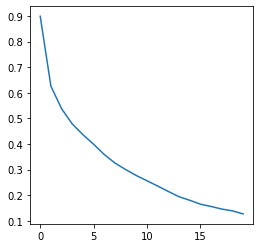

In [ ]:
loss_history = np.asarray(loss_history)
plt.figure(figsize=(4, 4))
plt.plot(loss_history[:,0], loss_history[:,1])
plt.show()